# **Image Captioning, comparação de decodificadores (LSTM, GRU, Transformer) para legendagem automática de imagens, usando CNN como codificador.. UnB/FCTE - 2025.2 - Professor Vinicius Rispoli.**

## **Visão Geral**

Este notebook implementa um sistema completo de legendagem automática de imagens utilizando arquitetura Encoder-Decoder para comparar o desempenho de três decoders diferentes: **LSTM**, **GRU** e **Transformer**.

### Justificativa das Escolhas de Arquitetura, Estratégia e Otimização

#### 1. Arquitetura Encoder-Decoder

**Por que Encoder-Decoder?**
- **Além dos requisitos do projeto proposto, ela é boa para separação de responsabilidades, modularidade e é um padrão de arquitetura amplamente utilizada.**
- **Separação de responsabilidades**: O encoder extrai características visuais complexas da imagem, enquanto o decoder gera texto sequencial. Essa divisão permite especialização de cada componente.
- **Padrão estabelecido**: Arquitetura amplamente utilizada e validada em tarefas de tradução imagem-texto, oferecendo boa base para comparação.
- **Modularidade**: Permite trocar decoders sem modificar o encoder, facilitando comparações justas entre diferentes abordagens.

#### 2. Encoder: ResNet-50 Pré-treinada

**Por que ResNet-50?**
- **Além dos pontos abaixo, ela foi escolhida principalmente pela familiaridade já que utilizei ela no primeiro projeto proposto e ela supriu bem.**
- **Transfer Learning**: A ResNet-50 foi pré-treinada no ImageNet (milhões de imagens), capturando características visuais genéricas úteis para diversas tarefas.
- **Profundidade adequada**: 50 camadas oferecem capacidade de representação suficiente sem excesso de complexidade computacional.
- **Disponibilidade**: Modelo pré-treinado facilmente acessível no PyTorch, seguindo os requisitos do projeto.
- **Congelamento de pesos**: Os pesos da ResNet são congelados para:
  - **Acelerar treinamento**: Reduz tempo de treinamento significativamente
  - **Evitar overfitting**: Previne que a rede "esqueça" features úteis aprendidas no ImageNet
  - **Comparação justa**: Garante que todos os decoders recebam as mesmas features visuais

**Por que apenas as camadas finais são treinadas?**
- Apenas a camada linear e batch normalization do encoder são treinadas junto com o primeiro decoder (LSTM) para mapear as features de 2048 dimensões para o tamanho de embedding (256).
- Isso permite adaptação sutil às características do dataset mantendo as features gerais aprendidas no ImageNet.

#### 3. Decoders: LSTM, GRU e Transformer

**Por que comparar esses três?**
- **Além de um dos requisitos do projeto proposto, serviu para um benchmark de RNNs.**
- **LSTM (Long Short-Term Memory)**: Arquitetura clássica para sequências, com capacidade de manter informação de longo prazo através de células de memória. Amplamente usada em Image Captioning.
- **GRU (Gated Recurrent Unit)**: Versão simplificada da LSTM, mais eficiente computacionalmente, mantendo capacidade de processar sequências.
- **Transformer**: Arquitetura moderna baseada em atenção, que permite processamento paralelo e captura de dependências de longo alcance através de mecanismo de atenção.

**Objetivo da comparação**: Avaliar qual arquitetura de decoder oferece melhor desempenho na geração de legendas, considerando trade-offs entre qualidade, eficiência computacional e complexidade.

#### 4. Estratégia de Treinamento

**Por que treinar encoder apenas no primeiro modelo?**
- **Primeiro modelo (LSTM)**: Treina encoder (camadas finais) + decoder LSTM juntos
  - Permite adaptação inicial do encoder ao dataset
  - Estabelece baseline de features visuais otimizadas
- **Modelos seguintes (GRU e Transformer)**: Usam encoder já treinado e congelado
  - **Comparação justa**: Todos os decoders recebem exatamente as mesmas features
  - **Isolamento de variáveis**: Diferenças de desempenho são atribuídas apenas aos decoders
  - **Eficiência**: Reduz tempo de treinamento e uso de memória

**Por que Early Stopping?**
- **Previne overfitting**: Para o treinamento quando o modelo para de melhorar na validação
- **Economiza recursos**: Evita treinar por épocas desnecessárias economizando assim tempo de GPU
- **Paciência (patience=3)**: Permite algumas épocas sem melhoria antes de parar, evitando paradas prematuras

**Por que Learning Rate Scheduler?**
- **ReduceLROnPlateau**: Reduz a taxa de aprendizado quando a perda para de melhorar
- **Convergência melhor**: Taxas menores permitem ajustes finos nos pesos
- **Factor=0.1, Patience=1**: Reduz 10x após 1 época sem melhoria

#### 5. Hiperparâmetros Escolhidos

**Learning Rate (0.001)**:
- Valor padrão comum para Adam optimizer
- Balanceia velocidade de convergência e estabilidade
- Scheduler ajusta dinamicamente durante treinamento

**Embed Size (256)**:
- Tamanho intermediário que balanceia capacidade de representação e eficiência
- Suficiente para capturar informações semânticas das imagens e palavras
- Compatível com todos os decoders (LSTM, GRU, Transformer)

**Hidden Size (512)**:
- Para LSTM e GRU, oferece capacidade adequada de memória
- Dobro do embed_size permite representações mais ricas nos estados ocultos
- Balanceia desempenho e eficiência computacional

**Num Layers (2)**:
- Duas camadas permitem hierarquia de representações (baixo e alto nível)
- Evita overfitting que poderia ocorrer com mais camadas
- Mantém treinamento estável e eficiente

**Dropout (0.5 para RNN, 0.1 para Transformer)**:
- **RNN (0.5)**: Dropout alto previne overfitting em redes recorrentes, que são propensas a memorização
- **Transformer (0.1)**: Dropout menor é comum em Transformers, que já têm mecanismos de regularização (attention, layer norm)

**Batch Size (32)**:
- Balanceia uso de memória GPU e estabilidade do gradiente
- Tamanho adequado para datasets de tamanho médio como Flickr8k
- Permite processamento eficiente em GPUs modernas

**Weight Decay (1e-4)**:
- Regularização L2 para prevenir overfitting
- Valor padrão que não interfere excessivamente no treinamento
- Ajuda na generalização do modelo

**Freq Threshold (5)**:
- Palavras que aparecem menos de 5 vezes são mapeadas para `<unk>`
- Reduz tamanho do vocabulário, melhorando eficiência
- Mantém palavras relevantes enquanto filtra ruído

#### 6. Data Augmentation

**Por que augmentation apenas no treino?**
- **Treino**: RandomHorizontalFlip e RandomCrop aumentam variabilidade dos dados
  - Previne overfitting
  - Melhora generalização do modelo
- **Validação/Teste**: Transformações determinísticas (CenterCrop)
  - Avaliação consistente e reprodutível
  - Não introduz variação artificial nos dados de avaliação

#### 7. Métrica de Avaliação: BLEU

**Por que BLEU?**
- **Requisitos proposto**: Foi proposto que utilizássemos esta métrica para validação
- **Padrão da área**: Métrica amplamente aceita em Image Captioning e Machine Translation
- **Requisito do projeto**: Especificamente solicitada no trabalho
- **Avaliação objetiva**: Mede similaridade n-gram entre legendas geradas e referências
- **Múltiplos n-gramas**: BLEU-1 a BLEU-4 avaliam diferentes aspectos (palavras individuais até frases completas)

#### 8. Framework: PyTorch

**Por que PyTorch?**
- **Requisitos proposto**: Especificamente solicitado para CNN pré-treinada e TorchMetrics
- **Flexibilidade**: Permite implementação customizada dos decoders
- **Ecossistema**: Integração nativa com torchvision (ResNet) e torchmetrics (BLEU)
- **Debugging**: Facilita desenvolvimento e depuração das arquiteturas

## **Primeiro passo: preparação do ambiente de trabalho.**

Começamos importando as dependências como a biblioteca do google drive e montando o drive para utilizar no projeto. Após isto importamos a biblioteca e módulos que usaremos do pytorch. Em seguida verificamos se há GPU disponível. O framework escolhido foi o PyTorch devido a três motivos principais alinhados aos requisitos do projeto: primeiro, o documento do trabalho restringe o uso de uma "CNN pré-treinada do PyTorch" (como ResNet ou VGG) para atuar como o Encoder e extrair as características visuais da imagem. Segundo, o projeto exige o uso da métrica BLEU para a validação e aponta especificamente para a biblioteca TorchMetrics, fornecendo inclusive um código de exemplo que já utiliza torch. Finalmente, como o objetivo central é implementar e comparar três Decoders distintos (LSTM, GRU e Transformador), o PyTorch tem a flexibilidade necessária para construir e depurar essas arquiteturas, permitindo uma análise detalhada de seus desempenhos.

Esta célula monta o Google Drive no ambiente do Colab, permitindo acesso aos arquivos armazenados no Drive. Primeiro importamos a biblioteca `drive` do Google Colab e o módulo `os` para operações de sistema. Em seguida, usamos `drive.mount()` para montar o Drive no diretório `/content/drive`, o que nos permitirá acessar os datasets e modelos salvos posteriormente.

In [ ]:
# Importação da biblioteca do Google Drive para acesso aos arquivos armazenados
from google.colab import drive
# Importação do módulo os para operações de sistema de arquivos
import os

# Monta o Google Drive no diretório /content/drive do ambiente Colab
# Isso permite acessar arquivos armazenados e guardar novos arquivos no Drive durante a execução
drive.mount('/content/drive')

Mounted at /content/drive


Esta célula copia os dados do Google Drive para o ambiente local do Colab para acelerar o processamento. Define os caminhos de origem (no Drive) e destino (local), cria o diretório local, copia os arquivos de texto e o arquivo ZIP das imagens, descompacta as imagens e remove o ZIP para economizar espaço. Ao final, verifica se os arquivos foram copiados corretamente listando o conteúdo dos diretórios.

In [ ]:
print("Iniciando Cópia de Dados para o Ambiente Local")

# DEFINIÇÃO DE CAMINHOS
# Define os caminhos de origem no Google Drive onde os dados estão armazenados
DRIVE_TEXT_PATH = '/content/drive/MyDrive/ImageCaptioning/dataset/FlickrText'
DRIVE_IMAGE_ZIP_PATH = '/content/drive/MyDrive/ImageCaptioning/dataset/FlickrImage.zip'

# Define os caminhos de destino no ambiente local do Colab
# Copiar para local acelera o processamento em relação ao acesso direto ao Drive
LOCAL_DATA_PATH = '/content/local_data'
LOCAL_TEXT_PATH = os.path.join(LOCAL_DATA_PATH, 'FlickrText')
LOCAL_IMAGE_ZIP = os.path.join(LOCAL_DATA_PATH, 'FlickrImage.zip')

# CRIAÇÃO DO DIRETÓRIO LOCAL
# Cria o diretório local se ele não existir (exist_ok=True evita erro se já existir)
os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

# CÓPIA DOS ARQUIVOS DE TEXTO
# Copia recursivamente todos os arquivos de texto (legendas) do Drive para local
print(f"Copiando arquivos de texto de {DRIVE_TEXT_PATH}...")
!cp -r "{DRIVE_TEXT_PATH}" "{LOCAL_DATA_PATH}"

# CÓPIA DO ARQUIVO ZIP DAS IMAGENS
# Copia o arquivo ZIP compactado contendo todas as imagens
print(f"Copiando ZIP das imagens de {DRIVE_IMAGE_ZIP_PATH}...")
!cp "{DRIVE_IMAGE_ZIP_PATH}" "{LOCAL_DATA_PATH}"

# DESCOMPACTAÇÃO DAS IMAGENS
# Descompacta o arquivo ZIP das imagens no diretório local
print(f"Descompactando {LOCAL_IMAGE_ZIP}...")
# '-o' = sobrescrever arquivos existentes sem perguntar
# '-q' = não imprime os nomes de todos os arquivos descompactados
!unzip -o -q "{LOCAL_IMAGE_ZIP}" -d "{LOCAL_DATA_PATH}"

# LIMPEZA
# Remove o arquivo ZIP após descompactação para economizar espaço em disco
!rm "{LOCAL_IMAGE_ZIP}"
print("Zip local removido.")

# VERIFICAÇÃO DOS ARQUIVOS COPIADOS
# Verifica se os arquivos foram copiados corretamente listando o conteúdo
print("\nCópia Local Concluída")
print("Verificando arquivos locais:")
!ls -l {LOCAL_DATA_PATH}
print("\nVerificando arquivos de imagem (amostra):")
!ls -l {LOCAL_DATA_PATH}/FlickrImage | head

Iniciando Cópia de Dados para o Ambiente Local
Copiando arquivos de texto de /content/drive/MyDrive/ImageCaptioning/dataset/FlickrText...
Copiando ZIP das imagens de /content/drive/MyDrive/ImageCaptioning/dataset/FlickrImage.zip...
Descompactando /content/local_data/FlickrImage.zip...
Zip local removido.

Cópia Local Concluída
Verificando arquivos locais:
total 420
drwxr-xr-x 2 root root 421888 Nov  7 21:50 FlickrImage
drwx------ 2 root root   4096 Nov  7 21:49 FlickrText

Verificando arquivos de imagem (amostra):
total 1104816
-rw-r--r-- 1 root root 199606 Nov  2  2011 1000268201_693b08cb0e.jpg
-rw-r--r-- 1 root root 142258 Nov  2  2011 1001773457_577c3a7d70.jpg
-rw-r--r-- 1 root root 159390 Nov  2  2011 1002674143_1b742ab4b8.jpg
-rw-r--r-- 1 root root 153171 Nov  2  2011 1003163366_44323f5815.jpg
-rw-r--r-- 1 root root 120869 Nov  2  2011 1007129816_e794419615.jpg
-rw-r--r-- 1 root root 179368 Nov  2  2011 1007320043_627395c3d8.jpg
-rw-r--r-- 1 root root 169882 Nov  2  2011 100943411

Esta célula instala e configura as bibliotecas necessárias para o projeto. Instala o spaCy para processamento de linguagem natural e baixa o modelo de inglês `en_core_web_sm` para tokenização. Também instala o torchmetrics para cálculo da métrica BLEU. Em seguida, importa todas as bibliotecas essenciais: PyTorch para deep learning, PIL para processamento de imagens, pandas para manipulação de dados, matplotlib e seaborn para visualização, e outras ferramentas necessárias para o projeto.

In [ ]:
# INSTALAÇÃO DE BIBLIOTECAS EXTERNAS

# Instala o spaCy para processamento de linguagem natural e tokenização
!pip install spacy
# Baixa o modelo de inglês pré-treinado do spaCy para tokenização
!python -m spacy download en_core_web_sm
# Instala o torchmetrics para cálculo de métricas como BLEU
!pip install torchmetrics

# IMPORTAÇÕES DE BIBLIOTECAS

# Importa a função de cálculo de score BLEU do torchmetrics
from torchmetrics.functional.text import bleu_score
# Importa PIL (Pillow) para manipulação e processamento de imagens
from PIL import Image
# Importa os para operações de sistema de arquivos
import os
# Importa PyTorch para deep learning e tensores
import torch
# Importa pandas para manipulação de dados em formato tabular
import pandas as pd
# Importa módulos do PyTorch para redes neurais
import torch.nn as nn
# Importa otimizadores do PyTorch (Adam, SGD, etc.)
import torch.optim as optim
# Importa modelos pré-treinados do torchvision (ResNet, VGG, etc.)
import torchvision.models as models
# Importa transformações de imagem do torchvision
import torchvision.transforms as transforms
# Importa Dataset e DataLoader para carregamento eficiente de dados
from torch.utils.data import Dataset, DataLoader
# Importa função para padding de sequências (necessário para batches de legendas)
from torch.nn.utils.rnn import pad_sequence
# Importa spaCy para processamento de linguagem natural
import spacy
# Importa matplotlib para visualização e plotagem de gráficos
import matplotlib.pyplot as plt
# Importa seaborn para visualizações estatísticas mais elaboradas
import seaborn as sns
# Importa math para cálculos matemáticos
import math
# Importa time para medir o tempo de execução
import time
# Importa random para exibir imagens aleatórias
import random


# CARREGAMENTO DO MODELO DE LINGUAGEM DO SPACY
# Tenta carregar o modelo de inglês do spaCy
# Este modelo será usado para tokenizar as legendas em palavras
try:
    spacy_eng = spacy.load("en_core_web_sm")
    print("Modelo 'en_core_web_sm' do spacy carregado com sucesso.")
except OSError:
    # Se houver erro, informa ao usuário para reiniciar o ambiente
    print("Erro ao carregar o modelo do spacy. Tente reiniciar o ambiente de execução.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 129.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00
Modelo 'en_core_web_sm' do spacy carregado com sucesso.


Esta célula verifica e configura o dispositivo de processamento (GPU ou CPU). Usa `torch.cuda.is_available()` para verificar se há uma GPU CUDA disponível. Se houver GPU, o código utilizará CUDA para acelerar os cálculos; caso contrário, usará a CPU. Isso é essencial para o treinamento eficiente dos modelos de deep learning.

In [ ]:
# CONFIGURAÇÃO DO DISPOSITIVO DE PROCESSAMENTO
# Verifica se há GPU CUDA disponível e configura o dispositivo apropriado
# Se não houver GPU, usa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## **Segundo Passo: preparação dos dados.**

Construção da classe vocabulário que irá construir o vocabulário a partir das legendas de treino mapeando cada palavra a um índice numérico.

Esta célula define a classe `Vocabulary` que constrói e gerencia o vocabulário do dataset. A classe mantém dois dicionários: `itos` (índice para string) e `stoi` (string para índice), incluindo tokens especiais como `<pad>`, `<start>`, `<end>` e `<unk>`. O método `build_vocabulary` constrói o vocabulário a partir das legendas de treino, contando frequências e adicionando palavras que atingem um threshold mínimo. Os métodos `numericalize` e `decode` convertem texto em índices e vice-versa, respectivamente.

In [ ]:
class Vocabulary:
    """
    Classe para construção e gerenciamento do vocabulário do dataset.
    
    Esta classe mantém mapeamentos bidirecionais entre palavras e índices numéricos,
    permitindo converter texto em números e vice-versa.
    """
    
    def __init__(self, freq_threshold):
        """
        Inicializa o vocabulário com tokens especiais e configurações.
        
        Argumentos: freq_threshold (int): Frequência mínima que uma palavra deve aparecer para ser incluída no vocabulário. Palavras com frequência menor serão mapeadas para <unk>.
        """

        # TOKENS ESPECIAIS

        # Define os tokens especiais necessários para processamento de sequências:
        # <pad>: usado para preencher sequências menores que o tamanho máximo do batch
        # <start>: marca o início de uma legenda
        # <end>: marca o fim de uma legenda
        # <unk>: representa palavras desconhecidas (fora do vocabulário)
        # Índices: <pad>=0, <start>=1, <end>=2, <unk>=3
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}  # Índice para String
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}  # String para Índice

        # Armazena o threshold de frequência para filtrar palavras raras
        self.freq_threshold = freq_threshold
        # Carrega o tokenizador do spaCy para processar texto em inglês
        self.spacy_tokenizer = spacy.load("en_core_web_sm")

    def __len__(self):
        """
        Retorna o tamanho do vocabulário.
        
        Retorna: int: Número de palavras no vocabulário.
        """

        return len(self.itos)

    def tokenizer_eng(self, text):
        """
        Tokeniza texto em inglês e converte para minúsculas.
        
        Argumentos: text (str): Texto a ser tokenizado.
            
        Retorna: list[str]: Lista de palavras tokenizadas em minúsculas.
        """

        # Usa o tokenizador do spaCy para dividir o texto em palavras
        # Converte cada palavra para minúsculas para normalização
        return [tok.text.lower() for tok in self.spacy_tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        """
        Constrói o vocabulário a partir de uma lista de legendas.
        
        Conta a frequência de cada palavra e adiciona ao vocabulário apenas palavras que atingem o threshold de frequência mínimo. Isso reduz o tamanho do vocabulário e melhora a generalização do modelo.
        
        Argumentos: sentence_list (list[str]): Lista de todas as legendas de treino.
        """

        # Dicionário para contar frequências de cada palavra
        frequencies = {}
        # Começa o índice em 4, pois 0-3 são reservados para tokens especiais
        idx = 4

        # Itera sobre todas as legendas
        for sentence in sentence_list:
            # Tokeniza cada legenda em palavras
            for word in self.tokenizer_eng(sentence):
                # Incrementa a contagem de frequência da palavra
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                # Adiciona a palavra ao vocabulário quando atinge o threshold
                # Isso garante que apenas palavras com frequência suficiente sejam incluídas
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx  # Mapeia palavra -> índice
                    self.itos[idx] = word  # Mapeia índice -> palavra
                    idx += 1

    def numericalize(self, text):
        """
        Converte uma legenda (texto) em uma lista de índices numéricos.
        
        Argumentos: text (str): Legenda em formato de texto.
            
        Retorna: list[int]: Lista de índices correspondentes às palavras da legenda. Palavras desconhecidas são mapeadas para o índice de <unk>.
        """

        # Tokeniza o texto em palavras
        tokenized_text = self.tokenizer_eng(text)

        # Converte cada palavra para seu índice correspondente
        # Se a palavra não estiver no vocabulário, usa o índice de <unk>
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

    def decode(self, numericalized_caption):
        """
        Converte uma lista de índices numéricos de volta para uma frase (string).
        
        Usado após a geração de legendas pelo modelo para converter os índices preditos de volta para texto legível.
        
        Argumentos: numericalized_caption (list[int] ou Tensor): Lista de índices a serem decodificados.
            
        Retorna: str: Frase reconstruída a partir dos índices.
        """
        
        words = []
        # Itera sobre cada índice na legenda numérica
        for idx in numericalized_caption:
            # Converte tensor para int se necessário
            idx_item = idx.item() if hasattr(idx, 'item') else idx

            # Para a decodificação quando encontra o token <end>
            if idx_item == self.stoi["<end>"]:
                break

            # Ignora tokens <start> e <pad> na saída final
            # Apenas adiciona palavras reais à lista
            if idx_item not in [self.stoi["<start>"], self.stoi["<pad>"]]:
                words.append(self.itos[idx_item])

        # Junta todas as palavras em uma única string
        return " ".join(words)

Esta célula define duas classes essenciais para o carregamento de dados. `FlickrDataset` é uma classe Dataset do PyTorch que carrega imagens e suas legendas correspondentes, aplica transformações nas imagens e converte legendas em sequências numéricas usando o vocabulário. `MyCollate` é uma função de collate customizada que agrupa amostras em batches, aplicando padding nas legendas para que todas tenham o mesmo comprimento, necessário para processamento em lote.

In [ ]:
class FlickrDataset(Dataset):
    """
    Classe de Dataset do PyTorch para o dataset Flickr8k.
    
    Esta classe implementa a interface Dataset do PyTorch, permitindo carregar imagens e suas legendas correspondentes de forma eficiente durante o treinamento. Recebe um DataFrame pré-filtrado para o split específico (treino/validação/teste).
    """
    
    def __init__(self, root_dir, df, vocab, transform=None):
        """
        Inicializa o dataset.
        
        Argumentos: root_dir (str): Diretório onde as imagens estão armazenadas. df (pd.DataFrame): DataFrame contendo as legendas já filtradas para este conjunto (ex: apenas treino ou apenas validação). vocab (Vocabulary): Instância do vocabulário já construído e treinado. transform (callable, optional): Transformações do torchvision a serem aplicadas nas imagens (resize, normalize, etc.).
        """

        # Armazena o diretório raiz onde as imagens estão
        self.root_dir = root_dir
        # Armazena o DataFrame com as legendas
        self.df = df
        # Armazena as transformações de imagem
        self.transform = transform
        # Armazena o vocabulário para conversão texto <-> índices
        self.vocab = vocab

        # Extrai arrays numpy com os nomes das imagens e legendas do DataFrame
        # Isso acelera o acesso durante __getitem__
        self.images = self.df["image"].values
        self.captions = self.df["caption"].values

    def __len__(self):
        """
        Retorna o tamanho do dataset.
        
        Retorna: int: Número de amostras (imagem+legenda) no dataset.
        """

        return len(self.df)

    def __getitem__(self, index):
        """
        Carrega e retorna uma amostra do dataset.
        
        Argumentos: index (int): Índice da amostra a ser carregada.
            
        Retorna: tuple: (imagem_tensor, legenda_tensor) ou (None, None) se imagem não encontrada.
        """
        
        # CARREGAMENTO DA LEGENDA E IDENTIFICAÇÃO DA IMAGEM
        # Obtém a legenda e o nome da imagem correspondente
        caption = self.captions[index]
        img_id = self.images[index]
        # Constrói o caminho completo da imagem
        img_path = os.path.join(self.root_dir, img_id)

        # CARREGAMENTO DA IMAGEM
        try:
            # Abre a imagem e converte para RGB (garante 3 canais de cor)
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            # Se a imagem não for encontrada, retorna None para ser filtrada depois
            print(f"Aviso: Imagem não encontrada em {img_path}. Ignorando.")
            return None, None

        # APLICAÇÃO DE TRANSFORMAÇÕES
        # Aplica transformações na imagem (resize, normalize, etc.)
        # Essas transformações são essenciais para preparar a imagem para a CNN
        if self.transform:
            image = self.transform(image)

        # NUMERICALIZAÇÃO DA LEGENDA
        # Converte a legenda de texto para índices numéricos
        # Adiciona token <start> no início
        numericalized_caption = [self.vocab.stoi["<start>"]]
        # Adiciona os índices das palavras da legenda
        numericalized_caption += self.vocab.numericalize(caption)
        # Adiciona token <end> no final
        numericalized_caption.append(self.vocab.stoi["<end>"])

        # Retorna a imagem como tensor e a legenda como tensor
        return image, torch.tensor(numericalized_caption)


class MyCollate:
    """
    Função Collate customizada para agrupar amostras em batches.
    
    Esta classe implementa a lógica de collate_fn para o DataLoader, que é
    responsável por agrupar múltiplas amostras em um único batch. A principal
    funcionalidade é aplicar padding nas legendas para que todas tenham o
    mesmo comprimento dentro de um batch.
    """
    
    def __init__(self, pad_idx):
        """
        Inicializa a função de collate.
        
        Argumentos: pad_idx (int): Índice do token <pad> usado para preencher sequências menores.
        """
        self.pad_idx = pad_idx

    def __call__(self, batch):
        """
        Agrupa amostras em um batch, aplicando padding nas legendas.
        
        Argumentos: batch (list): Lista de tuplas (imagem, legenda) retornadas pelo dataset.
            
        Retorna: tuple: (imagens_tensor, legendas_tensor)
                    - imagens_tensor: Tensor de shape (batch_size, 3, H, W)
                    - legendas_tensor: Tensor de shape (batch_size, max_seq_len)
        """
        
        # FILTRAGEM DE AMOSTRAS INVÁLIDAS
        # Remove amostras que retornaram None (ex: imagem não encontrada)
        batch = [item for item in batch if item[0] is not None]
        if not batch:
            # Se não houver amostras válidas, retorna tensores vazios
            return torch.tensor([]), torch.tensor([])

        # SEPARAÇÃO DE IMAGENS E LEGENDAS
        # Adiciona dimensão de batch às imagens (de 3D para 4D)
        imgs = [item[0].unsqueeze(0) for item in batch]
        # Extrai as legendas (já são tensores 1D)
        targets = [item[1] for item in batch]

        # CONCATENAÇÃO DAS IMAGENS
        # Concatena todas as imagens em um único tensor
        # Todas as imagens têm o mesmo tamanho após as transformações
        imgs = torch.cat(imgs, dim=0)

        # PADDING DAS LEGENDAS
        # Aplica padding nas legendas para que todas tenham o mesmo comprimento
        # batch_first=True: formato de saída é (batch_size, max_seq_len)
        # padding_value: valor usado para preencher (índice do token <pad>)
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return imgs, targets

Esta célula carrega e prepara os dados do dataset Flickr8k para treinamento e validação. Define funções auxiliares para ler listas de imagens e carregar legendas do arquivo de tokens. Cria transformações diferentes para treino (com data augmentation como flip horizontal e crop aleatório) e validação (apenas resize e center crop). Constrói o vocabulário apenas com dados de treino, cria os DataLoaders para treino e validação, e testa se os dados estão sendo carregados corretamente verificando os shapes dos batches.

In [ ]:
# FUNÇÕES AUXILIARES PARA CARREGAMENTO DE DADOS

def read_image_list(file_path):
    """
    Lê arquivos de lista de imagens (train/dev/test)Images.txt.
    
    Esses arquivos contêm um nome de imagem por linha, identificando quais
    imagens pertencem a cada split (treino, validação ou teste).
    
    Argumentos: file_path (str): Caminho para o arquivo de lista de imagens.
        
    Retorna: list[str]: Lista de nomes de imagens (ex: ['1000268201_693b08cb0e.jpg', ...]).
    """

    with open(file_path, 'r') as f:
        # Lê todas as linhas, remove espaços em branco e retorna como lista
        images = [line.strip() for line in f.readlines()]
    return images

def load_captions(file_path):
    """
    Lê o arquivo de legendas Flickr8k.token.txt e o transforma em um DataFrame.
    
    O arquivo tem formato: 'image_name#caption_number \t caption'
    Cada imagem tem múltiplas legendas (geralmente 5).
    
    Argumentos: file_path (str): Caminho para o arquivo Flickr8k.token.txt.
        
    Retorna: pd.DataFrame: DataFrame com colunas 'image' e 'caption', onde cada linha representa uma legenda de uma imagem.
    """

    # Dicionário para mapear nome da imagem -> lista de legendas
    captions_map = {}
    
    with open(file_path, 'r') as f:
        for line in f.readlines():
            # Divide a linha pelo caractere de tabulação
            parts = line.strip().split('\t')
            # Ignora linhas mal formadas (sem tabulação)
            if len(parts) < 2:
                continue

            # Extrai informações: 'image_name#caption_number' e 'caption'
            image_info, caption = parts[0], parts[1]
            # Extrai apenas o nome da imagem (antes do '#')
            image_name = image_info.split('#')[0]

            # Adiciona a legenda à lista de legendas da imagem
            if image_name not in captions_map:
                captions_map[image_name] = []
            captions_map[image_name].append(caption)

    # CONVERSÃO PARA DATAFRAME
    # Converte o dicionário para um DataFrame no formato 'longo'
    # Cada linha representa uma legenda de uma imagem
    data = []
    for img_name, caption_list in captions_map.items():
        for cap in caption_list:
            data.append({'image': img_name, 'caption': cap})

    return pd.DataFrame(data)

# DEFINIÇÃO DE CAMINHOS DOS DADOS
# Define os caminhos para os diretórios de imagens e textos no ambiente local
DatasetImage_path = '/content/local_data/FlickrImage'
DatasetText_path = '/content/local_data/FlickrText'
print(f"Usando caminhos de dados LOCAIS: {DatasetImage_path}")

# Define os caminhos para os arquivos específicos do dataset
CAPTIONS_FILE = os.path.join(DatasetText_path, 'Flickr8k.token.txt')  # Arquivo com todas as legendas
TRAIN_FILE = os.path.join(DatasetText_path, 'Flickr_8k.trainImages.txt')  # Lista de imagens de treino
DEV_FILE = os.path.join(DatasetText_path, 'Flickr_8k.devImages.txt')  # Lista de imagens de validação

# DEFINIÇÃO DE TRANSFORMAÇÕES DE IMAGEM
# Cria transformações separadas para treino e validação
# Treino usa data augmentation para aumentar a variabilidade dos dados
# Validação usa transformações determinísticas para avaliação consistente
print("Definindo transformações (com Data Augmentation para treino)...")

# Transformação para TREINO (com data augmentation)
transform_train = transforms.Compose([
    # Redimensiona a imagem para 256 pixels (mantém proporção)
    transforms.Resize(256),
    # AUGMENTATION: Espelha a imagem horizontalmente com 50% de probabilidade
    # Isso aumenta a variabilidade sem alterar o significado da imagem
    transforms.RandomHorizontalFlip(p=0.5),
    # AUGMENTATION: Corta uma região aleatória de 224x224 pixels
    # Força o modelo a aprender características mais robustas
    transforms.RandomCrop(224),
    # Converte PIL Image para tensor PyTorch (valores de 0-255 para 0-1)
    transforms.ToTensor(),
    # Normaliza os valores usando média e desvio padrão do ImageNet
    # Esses valores são específicos para modelos pré-treinados no ImageNet
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Média para cada canal RGB
        std=[0.229, 0.224, 0.225]    # Desvio padrão para cada canal RGB
    )
])

# Transformação para VALIDAÇÃO/TESTE (sem augmentation)
transform_val = transforms.Compose([
    # Redimensiona para 256 pixels
    transforms.Resize(256),
    # Corta o centro da imagem (224x224) de forma determinística
    # Sem aleatoriedade para avaliação consistente
    transforms.CenterCrop(224),
    # Converte para tensor
    transforms.ToTensor(),
    # Normaliza usando os mesmos valores do ImageNet
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# CARREGAMENTO DE TODOS OS DADOS
# Carrega o arquivo principal com todas as legendas de todas as imagens
print("Carregando arquivo de legendas principal (Flickr8k.token.txt)...")
all_captions_df = load_captions(CAPTIONS_FILE)
print(f"Total de {len(all_captions_df)} legendas carregadas.")

# PREPARAÇÃO DOS DADOS DE TREINO
# Filtra as legendas para incluir apenas imagens do conjunto de treino
print("Preparando dados de TREINO...")
# Lê a lista de nomes de imagens que pertencem ao conjunto de treino
train_image_names = read_image_list(TRAIN_FILE)
# Filtra o DataFrame para manter apenas legendas das imagens de treino
train_df = all_captions_df[all_captions_df['image'].isin(train_image_names)]
print(f"Dados de treino: {len(train_df)} legendas para {len(train_image_names)} imagens.")

# CONSTRUÇÃO DO VOCABULÁRIO
# IMPORTANTE: O vocabulário é construído APENAS com dados de treino
# Isso evita "vazamento" de informações do conjunto de validação/teste
print("Construindo vocabulário...")
# Cria o vocabulário com threshold de frequência mínima = 5
# Palavras que aparecem menos de 5 vezes serão mapeadas para <unk>
vocab = Vocabulary(freq_threshold=5)
# Constrói o vocabulário a partir das legendas de treino
vocab.build_vocabulary(train_df['caption'].tolist())
vocab_size = len(vocab)
print(f"Tamanho do Vocabulário: {vocab_size} palavras.")

# Obtém o índice do token <pad> para usar no padding
pad_idx = vocab.stoi["<pad>"]

# CRIAÇÃO DO DATALOADER DE TREINO
# Cria o dataset de treino com transformações de augmentation
train_dataset = FlickrDataset(
    root_dir=DatasetImage_path,  # Diretório das imagens
    df=train_df,                  # DataFrame com legendas de treino
    vocab=vocab,                  # Vocabulário construído
    transform=transform_train     # Transformações com augmentation
)

# Cria o DataLoader para iterar sobre os dados de treino em batches
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,        # Número de amostras por batch
    num_workers=2,        # Número de processos paralelos para carregar dados
    shuffle=True,         # Embaralha os dados a cada época
    pin_memory=True,      # Acelera transferência de dados para GPU
    collate_fn=MyCollate(pad_idx=pad_idx)  # Função customizada para padding
)

# PREPARAÇÃO DOS DADOS DE VALIDAÇÃO
# Filtra as legendas para incluir apenas imagens do conjunto de validação
print("\nPreparando dados de VALIDAÇÃO...")
# Lê a lista de nomes de imagens que pertencem ao conjunto de validação
dev_image_names = read_image_list(DEV_FILE)
# Filtra o DataFrame para manter apenas legendas das imagens de validação
val_df = all_captions_df[all_captions_df['image'].isin(dev_image_names)]
print(f"Dados de validação: {len(val_df)} legendas para {len(dev_image_names)} imagens.")

# CRIAÇÃO DO DATALOADER DE VALIDAÇÃO
# Cria o dataset de validação com transformações determinísticas
val_dataset = FlickrDataset(
    root_dir=DatasetImage_path,  # Diretório das imagens
    df=val_df,                    # DataFrame com legendas de validação
    vocab=vocab,                  # IMPORTANTE: Usa o mesmo vocabulário do treino
    transform=transform_val      # Transformações sem augmentation
)

# Cria o DataLoader para validação
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,        # Mesmo tamanho de batch para consistência
    num_workers=2,        # Processos paralelos
    shuffle=False,       # Não embaralha na validação
    pin_memory=True,      # Acelera transferência para GPU
    collate_fn=MyCollate(pad_idx=pad_idx)  # Mesma função de collate
)

# TESTE DOS DATALOADERS
# Verifica se os DataLoaders estão funcionando corretamente
print("\n--- Teste dos DataLoaders ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tenta carregar um batch de treino para verificar
try:
    # Obtém o primeiro batch do DataLoader de treino
    images, captions = next(iter(train_loader))
    print(f"Shape do lote de treino (imagens): {images.shape}")
    print(f"Shape do lote de treino (legendas): {captions.shape}")

    # Obtém o primeiro batch do DataLoader de validação
    images_val, captions_val = next(iter(val_loader))
    print(f"Shape do lote de validação (imagens): {images_val.shape}")
    print(f"Shape do lote de validação (legendas): {captions_val.shape}")

    print("\nDataLoaders criados com sucesso!")
except Exception as e:
    # Se houver erro, informa o problema
    print(f"Erro ao testar DataLoaders: {e}")
    print("Verifique seus caminhos e a instalação das bibliotecas.")

Usando caminhos de dados LOCAIS: /content/local_data/FlickrImage
Definindo transformações (com Data Augmentation para treino)...
Carregando arquivo de legendas principal (Flickr8k.token.txt)...
Total de 40460 legendas carregadas.
Preparando dados de TREINO...
Dados de treino: 30000 legendas para 6000 imagens.
Construindo vocabulário...
Tamanho do Vocabulário: 2548 palavras.

Preparando dados de VALIDAÇÃO...
Dados de validação: 5000 legendas para 1000 imagens.

--- Teste dos DataLoaders ---
Shape do lote de treino (imagens): torch.Size([32, 3, 224, 224])
Shape do lote de treino (legendas): torch.Size([32, 24])
Shape do lote de validação (imagens): torch.Size([32, 3, 224, 224])
Shape do lote de validação (legendas): torch.Size([32, 23])

DataLoaders criados com sucesso!


## **Terceiro Passo: criação do Encoder CNN usando ResNet50.**

Encoder de CNN para extração de featur de imagens. A CNN escolhida foi a ResNet-50 pré-treinada sem a camada de classificação.

Esta célula define a classe `EncoderCNN` que utiliza uma ResNet-50 pré-treinada no ImageNet como extrator de características visuais. A ResNet é carregada com pesos pré-treinados, todos os seus parâmetros são congelados (não serão treinados), e a camada de classificação final é removida. Uma camada linear e batch normalization são adicionadas para mapear as features de 2048 dimensões para o tamanho de embedding desejado, que será usado como entrada para os decoders.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size): # Parâmetro embed_size: O tamanho vetor de embedding de saída, que será usado como entrada para o Decoder

        super(EncoderCNN, self).__init__()

        # Carregar ResNet-50 pré-treinada no ImageNet
        # Usamos 'weights' para garantir que estamos pegando a versão pré-treinada
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Congelar todos os parâmetros da ResNet
        # Queremos usar a rede apenas como extratora de features, sem treiná-la.
        for param in resnet.parameters():
            param.requires_grad = False

        # Remover a camada de classificação (a última camada, 'fc')
        # Preservamos todas as camadas, exceto a última.
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Adicionar uma camada linear para mapear as features ao 'embed_size'
        # A saída da ResNet-50 (após o pooling) é um vetor de 2048 features.
        # 'resnet.fc.in_features' é uma forma segura de pegar esse número (2048)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # Adicionar Batch Normalization
        # Ajuda a estabilizar a entrada para o Decoder
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):

        # Extrair features com a ResNet
        # Saída de self.resnet: (batch_size, 2048, 1, 1)
        features = self.resnet(images)

        # Redimensionar o tensor
        # Queremos (batch_size, 2048) para passar pela camada linear
        features = features.reshape(features.size(0), -1)

        # Mapear para o embed_size
        # A camada de Batch Normalization (bn) espera (batch_size, num_features)
        features = self.bn(self.linear(features))

        return features

## **Quarto Passo: criação dos Decoders (LSTM, GRU e Transformer).**

 ### **Decoder RNN usando LSTM.**

Esta célula implementa o decoder baseado em LSTM (Long Short-Term Memory). O decoder recebe as features da imagem do encoder e gera legendas palavra por palavra. Utiliza uma camada de embedding para converter índices de palavras em vetores, uma LSTM para processar a sequência, e uma camada linear final para mapear os estados ocultos para o vocabulário. O método `forward` é usado durante o treinamento, enquanto `sample` é usado para gerar legendas durante a inferência, usando decodificação greedy.

In [ ]:
import torch
import torch.nn as nn

class DecoderLSTM(nn.Module):
    """
    Decoder RNN usando LSTM.
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        """
        Argumentos:
            embed_size (int): Tamanho do vetor de embedding (deve ser igual ao 'embed_size' do Encoder).
            hidden_size (int): Tamanho da camada oculta da LSTM.
            vocab_size (int): Tamanho do vocabulário (para a saída).
            num_layers (int): Número de camadas da LSTM.
            dropout (float): Probabilidade de dropout.
        """
        super(DecoderLSTM, self).__init__()

        # Camada de Embedding: converte índices de palavras em vetores
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Camada LSTM:
        # batch_first=True faz com que os tensores de entrada/saída sejam (batch_size, seq_len, features)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)

        # Camada Linear Final: mapeia o estado oculto da LSTM para o vocabulário
        self.linear = nn.Linear(hidden_size, vocab_size)

        # Camada de Dropout
        self.dropout = nn.Dropout(dropout)

        # Camadas para inicializar os estados oculto e de célula a partir das features da imagem
        # O Encoder nos dá 'embed_size', mas a LSTM precisa de 'hidden_size'
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        """
        Define a passagem 'para frente' (forward pass) durante o TREINAMENTO.

        Argumentos:
            features (Tensor): Vetor de features da imagem (do Encoder).
                            Shape: (batch_size, embed_size)
            captions (Tensor): Legendas de referência (ground-truth).
                            Shape: (batch_size, seq_len)
        """

        # Processar Legendas de Entrada
        # Ignoramos o token <end> no final da sequência de entrada
        # Shape: (batch_size, seq_len-1, embed_size)
        embeddings = self.dropout(self.embedding(captions[:, :-1]))

        # Inicializar estados ocultos (h0) e de célula (c0)
        # Usamos o vetor 'features' da imagem como contexto inicial
        # .unsqueeze(0) adiciona a dimensão 'num_layers'
        # .repeat(num_layers, 1, 1) garante que temos estados para todas as camadas
        h0 = self.init_h(features).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c0 = self.init_c(features).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)

        # Passar pela LSTM
        # 'outputs' contém o estado oculto para cada passo de tempo
        # Shape outputs: (batch_size, seq_len-1, hidden_size)
        outputs, _ = self.lstm(embeddings, (h0, c0))

        # Mapear para o vocabulário
        # Shape outputs: (batch_size, seq_len-1, vocab_size)
        outputs = self.linear(outputs)

        return outputs

    def sample(self, features, max_len=20):
        """
        Define a geração de legenda (inferência/amostragem) para UMA imagem.

        Argumentos:
            features (Tensor): Vetor de features da imagem (do Encoder).
                            Shape: (1, embed_size)
            max_len (int): Comprimento máximo da legenda a ser gerada.
        """
        
        # Lista para armazenar os índices das palavras geradas
        caption_indices = []

        # Inicializa estados ocultos (como no 'forward')
        h = self.init_h(features).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c = self.init_c(features).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)

        # O input inicial é o token <start>
        # (Assumindo que <start> tem índice 1 no vocabulário)
        inputs = torch.tensor([1], dtype=torch.long).to(features.device)
        inputs = self.embedding(inputs).unsqueeze(1) # Shape: (1, 1, embed_size)

        for _ in range(max_len):
            # Passa o input e os estados pela LSTM
            # Shape output: (1, 1, hidden_size)
            outputs, (h, c) = self.lstm(inputs, (h, c))

            # Mapeia para o vocabulário
            # Shape scores: (1, vocab_size)
            scores = self.linear(outputs.squeeze(1))

            # Pega a palavra com maior pontuação (método "greedy")
            predicted_idx = scores.argmax(1) # Shape: (1)

            # Armazena a palavra gerada
            caption_indices.append(predicted_idx.item())

            # Verifica se gerou o token <end> (Assumindo índice 2)
            if predicted_idx.item() == 2:
                break

            # Prepara o input para o próximo passo de tempo
            # A palavra gerada agora é a entrada
            inputs = self.embedding(predicted_idx).unsqueeze(1)

        return caption_indices

### **Decoder usando GRU.**

Esta célula implementa o decoder baseado em GRU (Gated Recurrent Unit), similar ao LSTM mas com arquitetura mais simples. A GRU possui apenas um estado oculto (diferente da LSTM que tem estado oculto e estado de célula), tornando-a computacionalmente mais eficiente. A estrutura geral é similar: embedding, camada GRU, e camada linear de saída. Os métodos `forward` e `sample` funcionam de forma análoga ao decoder LSTM.

In [ ]:
import torch
import torch.nn as nn

class DecoderGRU(nn.Module):
    """
    Decoder RNN usando GRU.
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        """
        Argumentos:
            embed_size (int): Tamanho do vetor de embedding (deve ser igual ao 'embed_size' do Encoder).
            hidden_size (int): Tamanho da camada oculta da GRU.
            vocab_size (int): Tamanho do vocabulário (para a saída).
            num_layers (int): Número de camadas da GRU.
            dropout (float): Probabilidade de dropout.
        """
        super(DecoderGRU, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)

        # A única diferença principal é nn.GRU em vez de nn.LSTM
        self.gru = nn.GRU(embed_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

        # A GRU só precisa de um estado oculto (h0), não de um estado de célula (c0)
        self.init_h = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        """
        Define a passagem 'para frente' (forward pass) durante o treinamento.
        """

        # Processar Legendas de Entrada
        embeddings = self.dropout(self.embedding(captions[:, :-1]))

        # Inicializar estado oculto (h0)
        # (Não há c0 na GRU)
        h0 = self.init_h(features).unsqueeze(0).repeat(self.gru.num_layers, 1, 1)

        # Passar pela GRU
        outputs, _ = self.gru(embeddings, h0)

        # Mapear para o vocabulário
        outputs = self.linear(outputs)

        return outputs

    def sample(self, features, max_len=20):
        """
        Define a geração de legenda (inferência/amostragem) para UMA imagem.
        """
        caption_indices = []

        # Inicializa o estado oculto
        h = self.init_h(features).unsqueeze(0).repeat(self.gru.num_layers, 1, 1)

        # Input inicial (<start> token)
        inputs = torch.tensor([1], dtype=torch.long).to(features.device)
        inputs = self.embedding(inputs).unsqueeze(1) # Shape: (1, 1, embed_size)

        for _ in range(max_len):
            outputs, h = self.gru(inputs, h) # GRU retorna o novo estado 'h'
            scores = self.linear(outputs.squeeze(1))
            predicted_idx = scores.argmax(1)

            caption_indices.append(predicted_idx.item())

            if predicted_idx.item() == 2: # <end> token
                break

            inputs = self.embedding(predicted_idx).unsqueeze(1)

        return caption_indices

### **Decoder usando transformer.**

Esta célula implementa o decoder baseado em arquitetura Transformer. Inclui uma classe auxiliar `PositionalEncoding` para adicionar informação posicional aos embeddings, já que o Transformer não tem noção inerente de sequência. O decoder usa camadas de TransformerDecoder com atenção multi-head. Durante o treinamento, usa uma máscara "look-ahead" para evitar que o modelo veja palavras futuras. O método `sample` para inferência é mais complexo que nos RNNs, pois precisa reconstruir a sequência completa a cada passo.

In [ ]:
# CLASSE AUXILIAR: Positional Encoding
# O Transformer não tem noção de sequência, então precisamos injetar
# informação sobre a posição de cada palavra.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)

        # 'register_buffer' torna 'pe' parte do estado do modelo,
        # mas não um parâmetro a ser treinado.
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # Adiciona o encoding posicional aos embeddings
        x = x + self.pe[:, :x.size(1), :]
        return x


class DecoderTransformer(nn.Module):
    """
    Decoder baseado em Transformer.
    """
    def __init__(self, embed_size, nhead, num_decoder_layers, dim_feedforward, vocab_size, dropout=0.1):
        """
        Argumentos:
            embed_size (int): Tamanho do embedding (d_model).
            nhead (int): Número de "cabeças" de atenção (ex: 8).
            num_decoder_layers (int): Número de camadas do decoder (ex: 6).
            dim_feedforward (int): Dimensão da camada feedforward (ex: 2048).
            vocab_size (int): Tamanho do vocabulário.
        """
        super(DecoderTransformer, self).__init__()

        self.embed_size = embed_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)

        # Camada do Decoder do Transformer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
        )

        # Camada linear final
        self.fc_out = nn.Linear(embed_size, vocab_size)

        # O Encoder nos dá (batch, embed_size). O Decoder espera (batch, seq_len, embed_size).
        # Vamos usar uma camada para projetar o 'embed_size' do encoder
        # para o 'embed_size' (d_model) do decoder, se necessário.
        # (Neste exemplo, assumimos que são iguais).

    def generate_square_subsequent_mask(self, sz):
        """
        Gera uma máscara "look-ahead" para que o decoder não "veja"
        palavras futuras durante o treinamento.
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, features, captions):
        """
        Define a passagem 'para frente' (forward pass) durante o TREINAMENTO.

        Argumentos:
            features (Tensor): Vetor de features da imagem (do Encoder).
                            Shape: (batch_size, embed_size)
            captions (Tensor): Legendas de referência (ground-truth).
                            Shape: (batch_size, seq_len)
        """

        # Preparar 'memory' (saída do Encoder)
        # O Decoder espera (batch, seq_len_memoria, embed_size)
        # Vamos adicionar uma dimensão de sequência de tamanho 1
        # Shape memory: (batch_size, 1, embed_size)
        memory = features.unsqueeze(1)

        # Preparar 'tgt' (legenda alvo)
        # Pegamos até a penúltima palavra (sem <end>)
        tgt_captions = captions[:, :-1]
        seq_len = tgt_captions.shape[1]

        # Gerar máscara "look-ahead"
        tgt_mask = self.generate_square_subsequent_mask(seq_len).to(features.device)

        # Obter embeddings e adicionar encoding posicional
        # Shape tgt_emb: (batch_size, seq_len-1, embed_size)
        tgt_emb = self.embedding(tgt_captions) * math.sqrt(self.embed_size)
        tgt_emb = self.pos_encoder(tgt_emb)

        # Passar pelo Decoder do Transformer
        output = self.transformer_decoder(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=tgt_mask
        )

        # Mapear para o vocabulário
        output = self.fc_out(output)

        return output

    # (Nota: A função 'sample' para o Transformer é mais complexa porque o 'tgt' cresce a cada passo. Por simplicidade, ela é omitida aqui, mas o 'forward' é o principal para o treino.)

    def sample(self, features, max_len=20):
        """
        Gera legendas (inferência) para o Transformer.
        Esta lógica é diferente do RNN, pois a sequência de entrada cresce.

        Argumentos:
            features (Tensor): Vetor de features (memory). Shape: (1, embed_size)
            max_len (int): Comprimento máximo.
        """

        # (Assumindo que <start>=1 e <end>=2, e 'vocab' está acessível)
        # Se 'vocab' não estiver acessível, passe os índices <start> e <end>
        start_token_idx = 1 # vocab.stoi["<start>"]
        end_token_idx = 2   # vocab.stoi["<end>"]

        # O 'memory' do Transformer
        memory = features.unsqueeze(1) # Shape: (1, 1, embed_size)

        # Inicia a legenda com o token <start>
        # Shape: (1, 1)
        tgt_indices = torch.tensor([start_token_idx], dtype=torch.long).to(features.device).unsqueeze(0)

        for _ in range(max_len):
            seq_len = tgt_indices.shape[1]

            # Obter embeddings e encoding posicional
            tgt_emb = self.embedding(tgt_indices) * math.sqrt(self.embed_size)
            tgt_emb = self.pos_encoder(tgt_emb)

            # Criar máscara look-ahead
            tgt_mask = self.generate_square_subsequent_mask(seq_len).to(features.device)

            # Passar pelo decoder
            output = self.transformer_decoder(
                tgt=tgt_emb,
                memory=memory,
                tgt_mask=tgt_mask
            )

            # Obter scores da ÚLTIMA palavra
            # output shape: (1, seq_len, vocab_size)
            last_word_scores = self.fc_out(output[:, -1, :]) # Shape: (1, vocab_size)

            # Pegar a palavra de maior score (greedy)
            predicted_idx = last_word_scores.argmax(1) # Shape: (1)

            # Adicionar a palavra à sequência de entrada
            # .unsqueeze(0) -> (1, 1)
            tgt_indices = torch.cat(
                [tgt_indices, predicted_idx.unsqueeze(0)], dim=1
            )

            # Parar se for <end>
            if predicted_idx.item() == end_token_idx:
                break

        # Retorna a lista de índices (sem o <start> inicial)
        return tgt_indices.squeeze(0)[1:].tolist()

## **Quinto Passo: treinamento.**

Configuração do Treinamento (Hiperparâmetros e Modelos), aqui definimos as variáveis que controlarão o processo de treinamento e inicializamos nossos modelos.

Esta célula configura todos os hiperparâmetros e a função de treinamento reutilizável. Define parâmetros comuns como taxa de aprendizado, número de épocas, tamanho de embedding, e parâmetros específicos para cada tipo de decoder (LSTM/GRU vs Transformer). Define a função de perda (CrossEntropyLoss) e a função `train_model` que executa o loop de treinamento, incluindo early stopping baseado na perda de validação, salvamento automático dos melhores modelos, e redução da taxa de aprendizado quando o modelo para de melhorar.

In [ ]:
# Definição do Dispositivo e Dados
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# (Assumindo que 'vocab', 'vocab_size', 'pad_idx', 'train_loader',
# 'val_loader', 'val_df', 'transform_train', 'transform_val' já existem)
vocab_size = len(vocab)
pad_idx = vocab.stoi["<pad>"]

print(f"Configuração Geral de Treinamento")
print(f"Usando dispositivo: {device}")
print(f"Tamanho do Vocabulário: {vocab_size}")

# Caminhos
MODEL_SAVE_PATH = '/content/drive/MyDrive/ImageCaptioning/models'
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

# Hiperparâmetros de Treinamento Comuns
LEARNING_RATE = 0.001
NUM_EPOCHS = 20      # Número MÁXIMO de épocas
EMBED_SIZE = 256
WEIGHT_DECAY = 1e-4  # Regularização L2 (Weight Decay)
PATIENCE = 3         # Paciência para o Early Stopping

# Hiperparâmetros Específicos dos Decoders
# Para LSTM e GRU
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT_RNN = 0.5

# Para Transformador
NHEAD = 8
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 1024
DROPOUT_TRANSFORMER = 0.1

# Função de Perda (Loss)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(device)
print("Configuração Concluída")

# Função de Treinamento Reutilizável
def train_model(encoder, decoder, optimizer, scheduler, criterion, train_loader, val_loader,
                model_name, num_epochs, model_save_path, device, vocab_size, pad_idx,
                patience=3, save_encoder=False):
    """
    Função reutilizável para treinar modelos de image captioning.
    
    Esta função implementa o loop completo de treinamento, incluindo:
    - Treinamento por épocas
    - Validação periódica
    - Early stopping baseado em perda de validação
    - Salvamento automático dos melhores modelos
    - Redução de taxa de aprendizado
    
    Argumentos:
        encoder: Modelo encoder (CNN) para extrair features das imagens
        decoder: Modelo decoder (LSTM/GRU/Transformer) para gerar legendas
        optimizer: Otimizador (ex: Adam) para atualizar os pesos
        scheduler: Scheduler para ajustar a taxa de aprendizado
        criterion: Função de perda (ex: CrossEntropyLoss)
        train_loader: DataLoader com dados de treino
        val_loader: DataLoader com dados de validação
        model_name: Nome do modelo (para logs e salvamento)
        num_epochs: Número máximo de épocas
        model_save_path: Caminho para salvar os modelos
        device: Dispositivo (cuda ou cpu)
        vocab_size: Tamanho do vocabulário
        pad_idx: Índice do token <pad>
        patience: Número de épocas sem melhoria antes de parar (early stopping)
        save_encoder: Se True, salva também o encoder (apenas para o primeiro modelo)
    """

    print(f"Iniciando treinamento do: {model_name.upper()}")

    # Inicialização de Variáveis de Controle
    # Melhor perda de validação encontrada até agora
    best_val_loss = float("inf")
    # Frequência de impressão de progresso durante o treino
    print_every_n_batches = 100
    # Total de batches para calcular médias
    total_train_batches = len(train_loader)
    total_val_batches = len(val_loader)
    # Contador para early stopping
    epochs_without_improvement = 0

    # Loop Principal de Treinamento
    for epoch in range(num_epochs):
        # Marca o início da época para calcular duração
        start_time_epoch = time.time()
        print(f"\nIniciando época {epoch+1}/{num_epochs} [Modelo: {model_name.upper()}] ---")

        # FASE DE TREINO
        encoder.train()
        decoder.train()
        train_loss = 0.0
        
        # Itera sobre todos os batches de treino
        for i, (images, captions) in enumerate(train_loader):
            # Move dados para o dispositivo (GPU ou CPU)
            images, captions = images.to(device), captions.to(device)
            
            # Zera os gradientes acumulados do passo anterior
            optimizer.zero_grad()
            
            # Forward pass: extrai features da imagem
            features = encoder(images)
            # Forward pass: gera predições de legendas
            outputs = decoder(features, captions)
            
            # Calcula a perda
            # Reshape necessário: (batch*seq_len, vocab_size) vs (batch*seq_len,)
            # captions[:, 1:] ignora o token <start> na entrada
            loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            
            # Backward pass: calcula gradientes
            loss.backward()
            # Atualiza os pesos do modelo
            optimizer.step()
            
            # Acumula a perda para calcular média
            train_loss += loss.item()
            
            # Imprime progresso a cada N batches
            if (i + 1) % print_every_n_batches == 0:
                print(f"Treino - Batch {i+1}/{total_train_batches} | Loss: {loss.item():.4f}")
        
        # Calcula perda média de treino
        avg_train_loss = train_loss / total_train_batches
        print(f"Treino - Fim da Época. Perda Média: {avg_train_loss:.4f}")

        # FASE DE VALIDAÇÃO
        encoder.eval()
        decoder.eval()
        val_loss = 0.0
        print("Iniciando Validação:")
        
        # Desabilita cálculo de gradientes durante validação (economiza memória)
        with torch.no_grad():
            # Itera sobre todos os batches de validação
            for i, (images, captions) in enumerate(val_loader):
                # Move dados para o dispositivo
                images, captions = images.to(device), captions.to(device)
                
                # Forward pass (sem backward, sem atualização de pesos)
                features = encoder(images)
                outputs = decoder(features, captions)
                loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
                
                # Acumula a perda
                val_loss += loss.item()
        
        # Calcula perda média de validação
        avg_val_loss = val_loss / total_val_batches
        epoch_time = time.time() - start_time_epoch

        # Impressão de Resultados e Ajuste de Learning Rate
        print(f"\nFim da época {epoch+1} (Duração: {epoch_time:.2f}s) ---")
        print(f"  - Perda de Treino (Avg): {avg_train_loss:.4f}")
        print(f"  - Perda de Validação (Avg): {avg_val_loss:.4f}")
        
        # Ajusta a taxa de aprendizado baseado na perda de validação
        # Se a perda não melhorar, reduz a taxa de aprendizado
        scheduler.step(avg_val_loss)

        # Verificação de Melhoria e Salvamento
        if avg_val_loss < best_val_loss:
            # Nova melhor perda encontrada
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0

            # Salva o decoder (sempre salva quando há melhoria)
            decoder_save_name = f"{model_name.upper()}_Decoder.pth"
            decoder_save_path = os.path.join(model_save_path, decoder_save_name)
            torch.save(decoder.state_dict(), decoder_save_path)
            print(f" - Nova melhor perda, Salvando modelo '{decoder_save_name}'...")

            # Salva o encoder apenas se o flag for True (apenas para o primeiro modelo)
            if save_encoder:
                encoder_save_name = "Resnet50_Encoder.pth"
                encoder_save_path = os.path.join(model_save_path, encoder_save_name)
                torch.save(encoder.state_dict(), encoder_save_path)
                print(f" - Salvando também '{encoder_save_name}'.")

        else:
            # Perda não melhorou nesta época
            epochs_without_improvement += 1
            print(f" - Perda de validação não melhorou. Paciência: {epochs_without_improvement}/{patience}")

        # EARLY STOPPING
        # Para o treinamento se não houver melhoria por 'patience' épocas
        if epochs_without_improvement >= patience:
            print(f" - Early Stopping na época: {epoch+1} ---")
            break

    print(f"\nTreinamento concluído para {model_name.upper()} ---")

Configuração Geral de Treinamento
Usando dispositivo: cuda
Tamanho do Vocabulário: 2548
Configuração Concluída


Definição dos modelos

Esta célula organiza os parâmetros e classes dos três decoders em dicionários para facilitar o treinamento iterativo. Cria um dicionário `decoder_params` com os hiperparâmetros específicos de cada modelo e um dicionário `models_to_run` mapeando nomes aos construtores das classes. Instancia o encoder global uma única vez, que será compartilhado entre todos os experimentos de decoders.

In [14]:
# --- 1. Definir os modelos e seus parâmetros ---
# (As classes DecoderLSTM, DecoderGRU, DecoderTransformer devem estar definidas)
# (Os hiperparâmetros devem estar definidos na célula anterior)

decoder_params = {
    "lstm": {
        'embed_size': EMBED_SIZE, 'hidden_size': HIDDEN_SIZE,
        'vocab_size': vocab_size, 'num_layers': NUM_LAYERS, 'dropout': DROPOUT_RNN
    },
    "gru": {
        'embed_size': EMBED_SIZE, 'hidden_size': HIDDEN_SIZE,
        'vocab_size': vocab_size, 'num_layers': NUM_LAYERS, 'dropout': DROPOUT_RNN
    },
    "transformer": {
        'embed_size': EMBED_SIZE, 'nhead': NHEAD,
        'num_decoder_layers': NUM_DECODER_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD, 'vocab_size': vocab_size, 'dropout': DROPOUT_TRANSFORMER
    }
}

models_to_run = {
    "lstm": DecoderLSTM,
    "gru": DecoderGRU,
    "transformer": DecoderTransformer
}

# --- 2. Instanciar o Encoder Global ---
# Instanciamos o Encoder AQUI, apenas uma vez.
encoder = EncoderCNN(EMBED_SIZE).to(device)
print("Encoder global instanciado.")

print("Dicionários 'decoder_params' e 'models_to_run' definidos.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


Encoder global instanciado.
Dicionários 'decoder_params' e 'models_to_run' definidos.


Treinamento LSTM

Esta célula executa o treinamento do modelo LSTM junto com o encoder. Como este é o primeiro modelo a ser treinado, tanto o decoder LSTM quanto as camadas treináveis do encoder (linear e batch normalization) são otimizadas juntas. Cria o otimizador Adam e um scheduler que reduz a taxa de aprendizado quando a perda de validação para de melhorar. O encoder treinado será salvo e reutilizado nos próximos experimentos (GRU e Transformer) com pesos congelados.

In [15]:
# --- TREINAMENTO (1/3): LSTM (E O ENCODER PRINCIPAL) ---

model_name = "lstm"
DecoderClass = models_to_run[model_name]

print(f"\nPreparando Experimento de Treino: {model_name.upper()} (e ENCODER)")

# 1. Instanciar Decoder
# (O 'encoder' é a variável global da Célula 12)
decoder_lstm = DecoderClass(**decoder_params[model_name]).to(device)

# 2. Instanciar Otimizador (Treina AMBOS os modelos)
params_to_train = (list(decoder_lstm.parameters()) +
                   list(encoder.linear.parameters()) +
                   list(encoder.bn.parameters()))
optimizer_lstm = optim.Adam(
    params=params_to_train, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# 3. Instanciar o Scheduler
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_lstm, mode='min', factor=0.1, patience=1
)

# --- B. Treinamento ---
# (Chamamos a função 'train_model' e ativamos o flag 'save_encoder')
train_model(
    encoder=encoder,  # <-- Usa o encoder global
    decoder=decoder_lstm,
    optimizer=optimizer_lstm,
    scheduler=scheduler_lstm,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name=model_name,
    num_epochs=NUM_EPOCHS,
    model_save_path=MODEL_SAVE_PATH,
    device=device,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
    patience=PATIENCE,
    save_encoder=True
)


Preparando Experimento de Treino: LSTM (e ENCODER)
Iniciando treinamento do: LSTM

Iniciando época 1/20 [Modelo: LSTM] ---
Treino - Batch 100/938 | Loss: 4.1449
Treino - Batch 200/938 | Loss: 3.8681
Treino - Batch 300/938 | Loss: 3.7630
Treino - Batch 400/938 | Loss: 3.6161
Treino - Batch 500/938 | Loss: 3.1380
Treino - Batch 600/938 | Loss: 3.3471
Treino - Batch 700/938 | Loss: 3.1859
Treino - Batch 800/938 | Loss: 3.1155
Treino - Batch 900/938 | Loss: 3.0226
Treino - Fim da Época. Perda Média: 3.5297
Iniciando Validação:

Fim da época 1 (Duração: 432.50s) ---
  - Perda de Treino (Avg): 3.5297
  - Perda de Validação (Avg): 3.0193
 - Nova melhor perda, Salvando modelo 'LSTM_Decoder.pth'...
 - Salvando também 'Resnet50_Encoder.pth'.

Iniciando época 2/20 [Modelo: LSTM] ---
Treino - Batch 100/938 | Loss: 2.7811
Treino - Batch 200/938 | Loss: 2.8499
Treino - Batch 300/938 | Loss: 3.0040
Treino - Batch 400/938 | Loss: 2.8741
Treino - Batch 500/938 | Loss: 3.1437
Treino - Batch 600/938 | L

Treinamento GRU

Esta célula treina o modelo GRU utilizando o encoder já treinado pelo LSTM. Primeiro carrega os pesos do encoder salvo anteriormente e congela todos os seus parâmetros (não serão atualizados). Apenas o decoder GRU é treinado, garantindo uma comparação justa entre os decoders, já que todos usam o mesmo encoder. O otimizador é configurado para atualizar apenas os parâmetros do decoder GRU.

In [16]:
# --- TREINAMENTO (2/3): GRU (COM ENCODER CONGELADO) ---

model_name = "gru"
DecoderClass = models_to_run[model_name]

print(f"\nPreparando Experimento de Treino: {model_name.upper()} ---")

# 1. Instanciar Encoder e CARREGAR PESOS
encoder_gru = EncoderCNN(EMBED_SIZE).to(device)
# --- MODIFICADO: Carrega o nome de arquivo correto ---
encoder_path = os.path.join(MODEL_SAVE_PATH, "Resnet50_Encoder.pth")
encoder_gru.load_state_dict(torch.load(encoder_path))

# --- MODIFICAÇÃO CHAVE: Congelar o Encoder ---
for param in encoder_gru.parameters():
    param.requires_grad = False
print("Encoder (Resnet50_Encoder.pth) carregado e congelado.")

# 2. Instanciar Decoder
decoder_gru = DecoderClass(**decoder_params[model_name]).to(device)

# 3. Instanciar Otimizador (Treina APENAS O DECODER)
params_to_train = decoder_gru.parameters() # <--- SÓ O DECODER
optimizer_gru = optim.Adam(
    params=params_to_train, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# 4. Instanciar o Scheduler
scheduler_gru = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_gru, mode='min', factor=0.1, patience=1
)

# --- B. Treinamento ---
# (Esta chamada está correta, ela usará o save_encoder=False por padrão)
train_model(
    encoder=encoder_gru,
    decoder=decoder_gru,
    optimizer=optimizer_gru,
    scheduler=scheduler_gru,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name=model_name,
    num_epochs=NUM_EPOCHS,
    model_save_path=MODEL_SAVE_PATH,
    device=device,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
    patience=PATIENCE
)


Preparando Experimento de Treino: GRU ---
Encoder (Resnet50_Encoder.pth) carregado e congelado.
Iniciando treinamento do: GRU

Iniciando época 1/20 [Modelo: GRU] ---
Treino - Batch 100/938 | Loss: 4.0546
Treino - Batch 200/938 | Loss: 3.2099
Treino - Batch 300/938 | Loss: 3.3567
Treino - Batch 400/938 | Loss: 3.0940
Treino - Batch 500/938 | Loss: 2.8551
Treino - Batch 600/938 | Loss: 3.0869
Treino - Batch 700/938 | Loss: 2.7941
Treino - Batch 800/938 | Loss: 3.1815
Treino - Batch 900/938 | Loss: 2.8510
Treino - Fim da Época. Perda Média: 3.2204
Iniciando Validação:

Fim da época 1 (Duração: 428.37s) ---
  - Perda de Treino (Avg): 3.2204
  - Perda de Validação (Avg): 2.8619
 - Nova melhor perda, Salvando modelo 'GRU_Decoder.pth'...

Iniciando época 2/20 [Modelo: GRU] ---
Treino - Batch 100/938 | Loss: 2.5075
Treino - Batch 200/938 | Loss: 2.7032
Treino - Batch 300/938 | Loss: 2.7554
Treino - Batch 400/938 | Loss: 2.6926
Treino - Batch 500/938 | Loss: 2.8513
Treino - Batch 600/938 | Los

Treinamento Transformer

Esta célula treina o modelo Transformer seguindo a mesma estratégia do GRU: carrega o encoder pré-treinado e o congela, treinando apenas o decoder Transformer. Isso mantém a consistência experimental, permitindo comparar o desempenho dos três decoders (LSTM, GRU e Transformer) quando todos utilizam o mesmo encoder de características visuais.

In [17]:
# --- TREINAMENTO (3/3): TRANSFORMER (COM ENCODER CONGELADO) ---

model_name = "transformer"
DecoderClass = models_to_run[model_name]

print(f"\nPreparando Experimento de Treino: {model_name.upper()} ---")

# 1. Instanciar Encoder e CARREGAR PESOS
encoder_transformer = EncoderCNN(EMBED_SIZE).to(device)
# --- MODIFICADO: Carrega o nome de arquivo correto ---
encoder_path = os.path.join(MODEL_SAVE_PATH, "Resnet50_Encoder.pth")
encoder_transformer.load_state_dict(torch.load(encoder_path))

# --- MODIFICAÇÃO CHAVE: Congelar o Encoder ---
for param in encoder_transformer.parameters():
    param.requires_grad = False
print("Encoder (Resnet50_Encoder.pth) carregado e congelado.")

# 2. Instanciar Decoder
decoder_transformer = DecoderClass(**decoder_params[model_name]).to(device)

# 3. Instanciar Otimizador (Treina APENAS O DECODER)
params_to_train = decoder_transformer.parameters() # <--- SÓ O DECODER
optimizer_transformer = optim.Adam(
    params=params_to_train, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# 4. Instanciar o Scheduler
scheduler_transformer = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_transformer, mode='min', factor=0.1, patience=1
)

# --- B. Treinamento ---
# (Esta chamada está correta, ela usará o save_encoder=False por padrão)
train_model(
    encoder=encoder_transformer,
    decoder=decoder_transformer,
    optimizer=optimizer_transformer,
    scheduler=scheduler_transformer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name=model_name,
    num_epochs=NUM_EPOCHS,
    model_save_path=MODEL_SAVE_PATH,
    device=device,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
    patience=PATIENCE
)


Preparando Experimento de Treino: TRANSFORMER ---
Encoder (Resnet50_Encoder.pth) carregado e congelado.
Iniciando treinamento do: TRANSFORMER

Iniciando época 1/20 [Modelo: TRANSFORMER] ---
Treino - Batch 100/938 | Loss: 3.5598
Treino - Batch 200/938 | Loss: 3.0655
Treino - Batch 300/938 | Loss: 3.3829
Treino - Batch 400/938 | Loss: 2.9506
Treino - Batch 500/938 | Loss: 2.8990
Treino - Batch 600/938 | Loss: 2.9061
Treino - Batch 700/938 | Loss: 2.6706
Treino - Batch 800/938 | Loss: 2.8484
Treino - Batch 900/938 | Loss: 2.6593
Treino - Fim da Época. Perda Média: 3.1391
Iniciando Validação:

Fim da época 1 (Duração: 438.12s) ---
  - Perda de Treino (Avg): 3.1391
  - Perda de Validação (Avg): 2.8401
 - Nova melhor perda, Salvando modelo 'TRANSFORMER_Decoder.pth'...

Iniciando época 2/20 [Modelo: TRANSFORMER] ---
Treino - Batch 100/938 | Loss: 2.7171
Treino - Batch 200/938 | Loss: 2.4916
Treino - Batch 300/938 | Loss: 2.5666
Treino - Batch 400/938 | Loss: 2.4530
Treino - Batch 500/938 | L

## **Sexto Passo: validação com BLEU.**

Esta célula avalia todos os modelos treinados usando a métrica BLEU (Bilingual Evaluation Understudy). Para cada modelo (LSTM, GRU, Transformer), carrega os pesos salvos, gera legendas para todas as imagens de validação, e calcula os scores BLEU-1, BLEU-2, BLEU-3 e BLEU-4. Os scores BLEU medem a similaridade entre as legendas geradas e as legendas de referência, considerando n-gramas de diferentes tamanhos. Os resultados são organizados em uma tabela comparativa.

In [ ]:
print("Iniciando Avaliação BLEU (Relatório Completo)")

# Definir Modelos para Avaliar
# (Assumindo que todas as variáveis de setup existem)

comparison_results_list = []
print_every_n_images = 200 # Para mostrar o progresso

# Preparar Dados de Referência (Uma única vez)
val_unique_images = val_df['image'].unique()
all_references_map = val_df.groupby('image')['caption'].apply(list).to_dict()
print(f"Dados de referência carregados. {len(val_unique_images)} imagens únicas para avaliar.")

# Loop Principal de Avaliação
for model_name, DecoderClass in models_to_run.items():

    print("\n------------------------------------------------")
    print(f"   AVALIANDO MODELO (BLEU): {model_name.upper()}")
    print("-------------------------------------------------")

    # Instanciar Modelos (Vazios)
    encoder_eval = EncoderCNN(EMBED_SIZE).to(device)
    decoder_eval = DecoderClass(**decoder_params[model_name]).to(device)

    # Carregar Pesos do Melhor Modelo Salvo

    # Carrega o Encoder (Resnet50_Encoder.pth) para todos
    encoder_path = os.path.join(MODEL_SAVE_PATH, "Resnet50_Encoder.pth")

    # Carrega os Decoders
    decoder_name = f"{model_name.upper()}_Decoder.pth"
    decoder_path = os.path.join(MODEL_SAVE_PATH, decoder_name)

    # Fim da Modificação

    try:
        encoder_eval.load_state_dict(torch.load(encoder_path))
        decoder_eval.load_state_dict(torch.load(decoder_path))
        print(f"Pesos do melhor modelo ({model_name.upper()}) carregados.")
    except FileNotFoundError:
        print(f"ERRO: Arquivos de modelo (.pth) para '{model_name}' não encontrados.")
        print(f"Caminho procurado: {encoder_path} e {decoder_path}")
        continue

    # Colocar Modelos em Modo de Avaliação
    encoder_eval.eval()
    decoder_eval.eval()

    # Loop de Geração
    all_predictions = []
    all_references_list = []

    print(f"Gerando legendas para {len(val_unique_images)} imagens:")
    with torch.no_grad():
        for i, img_name in enumerate(val_unique_images):
            img_path = os.path.join(DatasetImage_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
            except FileNotFoundError:
                continue

            image_tensor = transform_val(image).unsqueeze(0).to(device)
            features = encoder_eval(image_tensor)
            predicted_indices = decoder_eval.sample(features)
            predicted_caption = vocab.decode(predicted_indices)
            references = all_references_map[img_name]
            all_predictions.append(predicted_caption)
            all_references_list.append(references)

            if (i + 1) % print_every_n_images == 0:
                print(f"Processado {i+1}/{len(val_unique_images)} imagens:")

    # Calcular e Imprimir o Score BLEU
    print("\nGeração concluída. Calculando scores BLEU...")

    # Calcular todos os 4 scores
    bleu_1 = bleu_score(all_predictions, all_references_list, n_gram=1)
    bleu_2 = bleu_score(all_predictions, all_references_list, n_gram=2)
    bleu_3 = bleu_score(all_predictions, all_references_list, n_gram=3)
    bleu_4 = bleu_score(all_predictions, all_references_list, n_gram=4)

    # Salva o resultado
    comparison_results_list.append({
        'Modelo': model_name.upper(),
        'BLEU-1 (%)': bleu_1.item() * 100,
        'BLEU-2 (%)': bleu_2.item() * 100,
        'BLEU-3 (%)': bleu_3.item() * 100,
        'BLEU-4 (%)': bleu_4.item() * 100
    })

    print(f"\nAvaliação BLEU Concluída ({model_name.upper()}) ---")
    print(f"\nExemplo de Legenda Gerada (Predição):")
    print(f"  -> {all_predictions[0]}")
    print(f"Exemplo de Legendas Reais (Referências):")
    for ref in all_references_list[0]:
        print(f"  -> {ref}")
    print("\n------------------------------------------------")
    print(f"Score BLEU-4 Formatado (%): {bleu_4.item() * 100:.2f}%")
    print("------------------------------------------------")

# Exibir Resultados Finais da Comparação
print("\n------------------------------------------------")
print("      RESULTADOS FINAIS DA COMPARAÇÃO (BLEU)")
print("------------------------------------------------")

# Converte a lista de resultados em um DataFrame do Pandas
results_df = pd.DataFrame(comparison_results_list)
results_df = results_df.set_index('Modelo')
results_df = results_df.sort_values(by='BLEU-4 (%)', ascending=False)
print(results_df)

print("\n--- Todos os experimentos foram avaliados! ---")

Iniciando Avaliação BLEU (Relatório Completo)
Dados de referência carregados. 1000 imagens únicas para avaliar.

------------------------------------------------
   AVALIANDO MODELO (BLEU): LSTM
-------------------------------------------------
Pesos do melhor modelo (LSTM) carregados.
Gerando legendas para 1000 imagens:
Processado 200/1000 imagens:
Processado 400/1000 imagens:
Processado 600/1000 imagens:
Processado 800/1000 imagens:
Processado 1000/1000 imagens:

Geração concluída. Calculando scores BLEU...

Avaliação BLEU Concluída (LSTM) ---

Exemplo de Legenda Gerada (Predição):
  -> three children are playing in the water .
Exemplo de Legendas Reais (Referências):
  -> A child and a woman are at waters edge in a big city .
  -> a large lake with a lone duck swimming in it with several people around the edge of it .
  -> A little boy at a lake watching a duck .
  -> A young boy waves his hand at the duck in the water surrounded by a green park .
  -> Two people are at the edge of 

## **Sétimo Passo: visualização dos dados de entrada e saída.**

Esta célula realiza uma análise visual qualitativa dos modelos, selecionando imagens aleatórias do conjunto de validação e gerando legendas com cada um dos três decoders. Para cada imagem, exibe a imagem original, as legendas geradas por cada modelo (LSTM, GRU, Transformer) e as legendas reais (ground truth) para comparação. Isso permite uma avaliação visual e qualitativa além das métricas numéricas, ajudando a entender os tipos de erros e acertos de cada modelo.

Iniciando Análise Visual...
Variáveis de validação ('val_df') encontradas.
Imagens selecionadas para demonstração: ['3457460673_800d7f7dd9.jpg', '397815951_3b02090324.jpg', '1032122270_ea6f0beedb.jpg']

Carregando modelos treinados (1 Encoder, 3 Decoders)...
Encoder (Resnet50_Encoder.pth) carregado com sucesso.
  Carregando LSTM...
    LSTM_Decoder.pth carregado com sucesso.
  Carregando GRU...
    GRU_Decoder.pth carregado com sucesso.
  Carregando TRANSFORMER...
    TRANSFORMER_Decoder.pth carregado com sucesso.

Gerando e exibindo legendas...


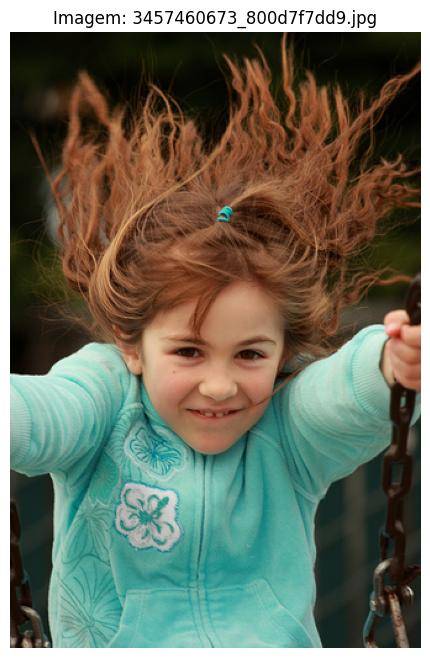


Legendas Geradas:
  - LSTM: a young girl in a pink shirt is playing with a green toy .
  - GRU: a young girl with a green shirt is smiling .
  - TRANSFORMER: a girl in a green shirt is playing in a green <unk> .

Legendas Reais (Ground Truth):
  - (Ref): A little girl swings while her hair flies in the wind .
  - (Ref): A little girl with red hair and a teal tracksuit on a swing .
  - (Ref): A redheaded girl with a turquoise jacket is swinging .
  - (Ref): A young girl wearing a blue sweatshirt smiles as her hair is up in the air .
  - (Ref): The young girl is swinging on a swing , and her hair is flying out behind her .
--------------------------------------------------


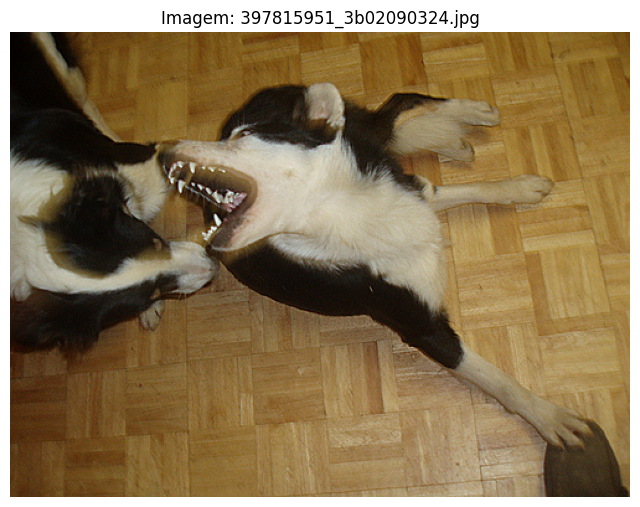


Legendas Geradas:
  - LSTM: a black and white dog is playing with a black and white dog .
  - GRU: a black and white dog is chasing a black and white dog .
  - TRANSFORMER: a black and white dog is playing with a ball .

Legendas Reais (Ground Truth):
  - (Ref): A dog 's mouth opens to expose its sharp teeth .
  - (Ref): a dog tries to bite another dog .
  - (Ref): two black and white dogs fighting with each other
  - (Ref): Two dogs play on the wooden floor inside .
  - (Ref): Two dogs play with each other on a wood floor .
--------------------------------------------------


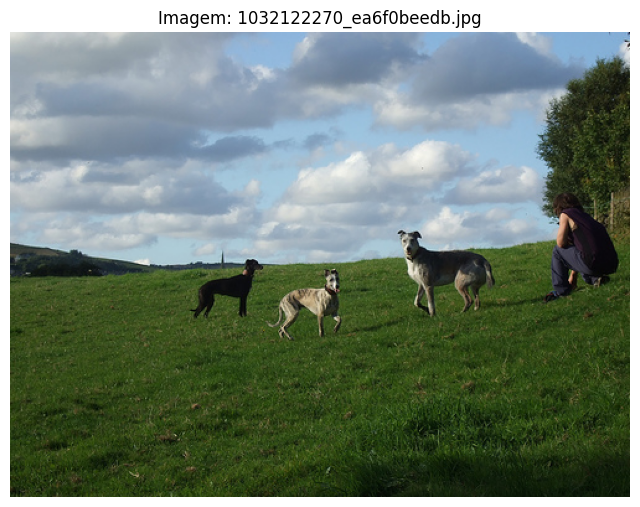


Legendas Geradas:
  - LSTM: three dogs play in the grass .
  - GRU: three dogs play in the grass .
  - TRANSFORMER: three dogs are playing in the grass .

Legendas Reais (Ground Truth):
  - (Ref): A woman crouches near three dogs in a field .
  - (Ref): Three dogs are playing on grassy hill with a blue sky .
  - (Ref): Three dogs are standing in the grass and a person is sitting next to them
  - (Ref): Three dogs on a grassy hill
  - (Ref): Three dogs stand in a grassy field while a person kneels nearby .
--------------------------------------------------


In [ ]:
print("Iniciando Análise Visual...")

# Selecionar Imagens para Visualização
# (Assumindo que as Células de setup 1-12 foram rodadas)
# (Isso recria as variáveis 'val_df' e 'all_references_map' se elas não existirem)

try:
    val_unique_images = val_df['image'].unique()
    all_references_map = val_df.groupby('image')['caption'].apply(list).to_dict()
    print("Variáveis de validação ('val_df') encontradas.")
except NameError:
    print("'val_df' não encontrado. Recriando a partir dos arquivos de texto...")
    # (Este é o código da Célula 6 para recarregar os dados de validação)
    try:
        DEV_FILE = os.path.join(DatasetText_path, 'Flickr_8k.devImages.txt')
        all_captions_df = load_captions(CAPTIONS_FILE) # Precisa do 'load_captions'
        dev_image_names = read_image_list(DEV_FILE) # Precisa do 'read_image_list'
        val_df = all_captions_df[all_captions_df['image'].isin(dev_image_names)]
        val_unique_images = val_df['image'].unique()
        all_references_map = val_df.groupby('image')['caption'].apply(list).to_dict()
        print("Dados de validação recarregados com sucesso.")
    except Exception as e:
        print(f"ERRO: Falha ao recarregar dados de validação. Rode as Células 1-6. Erro: {e}")
        # Trava o script se os dados não puderem ser carregados
        raise

num_demonstration_images = 3
demonstration_images = random.sample(list(val_unique_images), num_demonstration_images)
print(f"Imagens selecionadas para demonstração: {demonstration_images}")


# Carregar Modelos Treinados
print("\nCarregando modelos treinados (1 Encoder, 3 Decoders)...")
# (Assumindo que Células 11 e 12 foram rodadas para 'EMBED_SIZE', 'decoder_params', etc.)

loaded_decoders = {}
encoder_eval = None

try:
    # Carregar o Encoder
    encoder_path = os.path.join(MODEL_SAVE_PATH, "Resnet50_Encoder.pth")
    encoder_eval = EncoderCNN(EMBED_SIZE).to(device)
    encoder_eval.load_state_dict(torch.load(encoder_path, map_location=device))
    encoder_eval.eval()
    print("Encoder (Resnet50_Encoder.pth) carregado com sucesso.")

    # Carregar as 3 Decoders
    for model_name, DecoderClass in models_to_run.items():
        print(f"  Carregando {model_name.upper()}...")
        decoder_name = f"{model_name.upper()}_Decoder.pth"
        decoder_path = os.path.join(MODEL_SAVE_PATH, decoder_name)

        decoder_eval = DecoderClass(**decoder_params[model_name]).to(device)
        decoder_eval.load_state_dict(torch.load(decoder_path, map_location=device))
        decoder_eval.eval()

        loaded_decoders[model_name] = decoder_eval
        print(f"    {model_name.upper()}_Decoder.pth carregado com sucesso.")

except FileNotFoundError as e:
    print(f"ERRO: Arquivo de modelo não encontrado. {e}")
    print("Certifique-se de que treinou todos os modelos e os nomes dos arquivos estão corretos.")
except Exception as e:
    print(f"Erro ao carregar modelos: {e}")

# Gerar Legendas e Exibir Imagens e Legendas
if not loaded_decoders or encoder_eval is None:
    print("\nNenhum modelo foi carregado. Não é possível gerar legendas.")
else:
    print("\nGerando e exibindo legendas...")

    for img_name in demonstration_images:
        img_path = os.path.join(DatasetImage_path, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Imagem não encontrada em {img_path}. Pulando.")
            continue

        # Preparar tensor da imagem (usando 'transform_val')
        image_tensor = transform_val(image).unsqueeze(0).to(device)

        # Gera o Contexto Visual (Features)
        with torch.no_grad():
            features = encoder_eval(image_tensor)

        # Exibir a imagem
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Imagem: {img_name}")
        plt.axis('off')
        plt.show()

        print("\nLegendas Geradas:")
        # Alimenta as mesmas Features em todos os Decoders
        for model_name, decoder in loaded_decoders.items():
            with torch.no_grad():
                 predicted_indices = decoder.sample(features)

            predicted_caption = vocab.decode(predicted_indices)
            print(f"  - {model_name.upper()}: {predicted_caption}")

        # Exibir legendas reais
        print("\nLegendas Reais (Ground Truth):")
        for ref in all_references_map[img_name]:
            print(f"  - (Ref): {ref}")
        print("-" * 50) # Separador

## **Oitávo Passo: benchmark e análise dos decoders.**


Esta célula cria visualizações e análises comparativas dos resultados. Gera um gráfico de barras agrupado mostrando os scores BLEU-1, BLEU-2, BLEU-3 e BLEU-4 para cada modelo, facilitando a comparação visual do desempenho. Os dados são reorganizados em formato longo (melt) para compatibilidade com seaborn, e os valores são anotados em cima de cada barra. O gráfico é salvo no Drive para uso em relatórios.

Iniciando Benchmark e Análise
DataFrame 'results_df' encontrado. Usando resultados reais.

Resultados Finais (Tabela Completa):
             BLEU-1 (%)  BLEU-2 (%)  BLEU-3 (%)  BLEU-4 (%)
Modelo                                                     
GRU           59.473276   38.743713   25.385377   16.467130
LSTM          58.421814   37.973303   24.673203   15.918052
TRANSFORMER   57.948589   36.988595   24.033554   15.542325

Gráfico de benchmark salvo com sucesso em: /content/drive/MyDrive/ImageCaptioning/models/benchmark_bleu_full_report.png


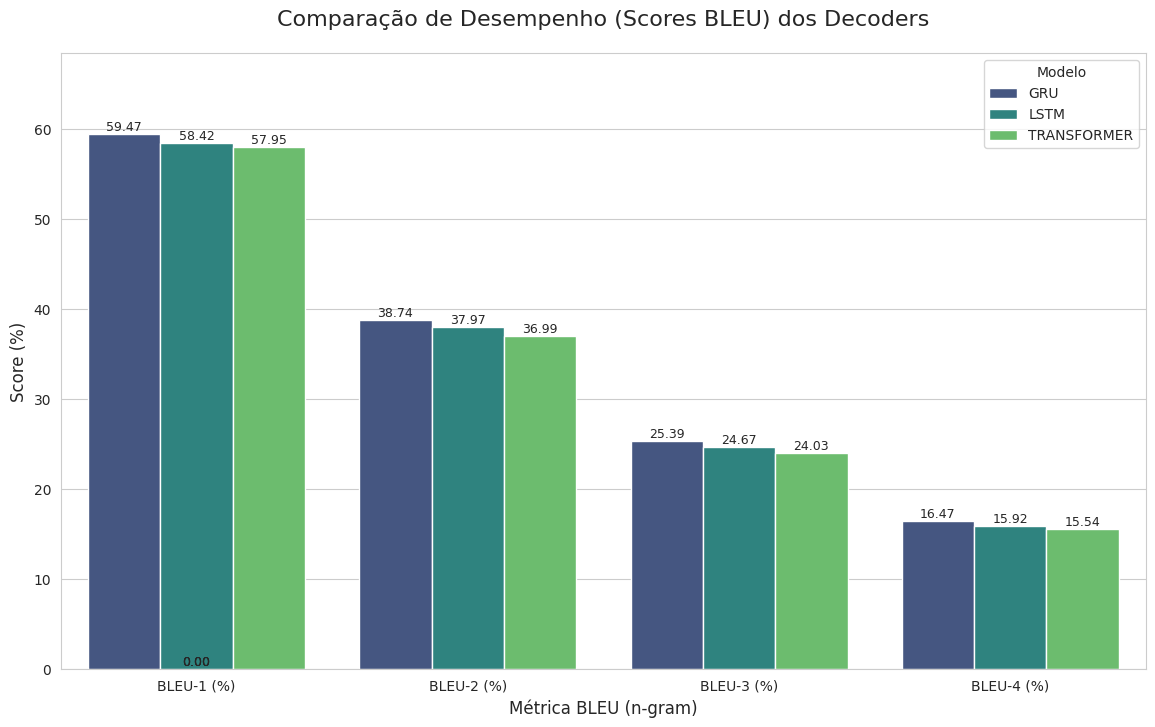

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

print("Iniciando Benchmark e Análise")

# Recriar/Verificar os dados de resultado
# (Se 'results_df' não estiver na memória, criamos um exemplo com 4 colunas)
if 'results_df' not in locals():
    print("DataFrame 'results_df' não encontrado. Criando um exemplo simulado...")
    # (Substitua estes valores pelos seus resultados reais)
    results_data = {
        'BLEU-1 (%)': {'GRU': 59.4, 'LSTM': 58.4, 'TRANSFORMER': 57.9},
        'BLEU-2 (%)': {'GRU': 38.7, 'LSTM': 37.9, 'TRANSFORMER': 36.9},
        'BLEU-3 (%)': {'GRU': 25.3, 'LSTM': 24.6, 'TRANSFORMER': 24.0},
        'BLEU-4 (%)': {'GRU': 16.4, 'LSTM': 15.9, 'TRANSFORMER': 15.5}
    }
    results_df = pd.DataFrame(results_data)
    results_df.index.name = 'Modelo'
else:
    print("DataFrame 'results_df' encontrado. Usando resultados reais.")

# Exibir a Tabela de Resultados Finais
# (Ordenamos pela métrica principal, BLEU-4)
results_df_sorted = results_df.sort_values(by='BLEU-4 (%)', ascending=False)
print("\nResultados Finais (Tabela Completa):")
print(results_df_sorted)

# Preparar os Dados para o Gráfico (Melting)
# O Seaborn prefere dados em formato longo para gráficos agrupados.
# Aplicamos melt para transformar dados de formato largo para longo.
results_df_long = results_df.reset_index().melt(
    id_vars='Modelo',
    var_name='Métrica',
    value_name='Score'
)

# Criar o Gráfico de Barras Agrupado
plt.figure(figsize=(14, 8)) # Aumenta o tamanho para caber tudo
sns.set_style("whitegrid")

# Cria o gráfico de barras agrupado
# x = As 4 métricas
# y = O score
# hue = O que agrupa (os 3 modelos)
ax = sns.barplot(
    data=results_df_long,
    x='Métrica',
    y='Score',
    hue='Modelo',
    palette='viridis' # Esquema de cores
)

# Adicionar Anotações e Títulos
plt.title('Comparação de Desempenho (Scores BLEU) dos Decoders', fontsize=16, pad=20)
plt.xlabel('Métrica BLEU (n-gram)', fontsize=12)
plt.ylabel('Score (%)', fontsize=12)
plt.legend(title='Modelo', loc='upper right')

# Coloca os valores em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.2f}', # Texto (ex: "16.42")
        (p.get_x() + p.get_width() / 2., height), # Posição
        ha='center',
        va='center',
        xytext=(0, 5), # Deslocamento vertical de 5 pontos
        textcoords='offset points',
        fontsize=9
    )

# Define um limite superior para o eixo Y para dar espaço ao texto
plt.ylim(0, results_df_long['Score'].max() * 1.15)

# Salva a imagem no Drive
benchmark_image_path = os.path.join(MODEL_SAVE_PATH, 'benchmark_bleu_full_report.png')
try:
    plt.savefig(benchmark_image_path)
    print(f"\nGráfico de benchmark salvo com sucesso em: {benchmark_image_path}")
except Exception as e:
    print(f"Erro ao salvar o gráfico: {e}")

plt.show()